In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import gc
gc.collect()

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler,MinMaxScaler



In [2]:
seasons = list(range(2009, 2020))

In [3]:
pbp = None

for season in seasons:
    path = './data/nflscrapR/play_by_play_data/regular_season/reg_pbp_{}.csv'.format(season)
    sea_pbp = pd.read_csv(path)
    
    if pbp is not None:
        pbp = pd.concat([pbp,sea_pbp],axis=0)
    else:
        pbp = sea_pbp

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (42,167,168,175,176,179,180,183,184,189,190,191,192,204,205,206,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (42,167,168,169,170,175,176,179,180,183,184,189,190,191,192,195,196,204,205,206,219,220,221,232,233,234,239,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (37,38,39,42,46,47,167,168,169,170,173,174,175,176,177,178,179,180,183,184,185,186,189,190,191,192,193,194,195,196,199,200,204,205,206,225,226,227,228,232,233,234,239,241,242,245,246,247,250,251) have mixed types. Sp

Step one. Create model that predicts run or pass.

In [4]:
# some renames
pbp = pbp.rename(columns={'yardline_100':'yards_for_td'})

pbp['is_home'] = np.where(pbp['home_team']==pbp['posteam'],1,0)
pbp['half'] = np.where(pbp['game_seconds_remaining'] > 1800, 0, 1)


In [5]:
pbp.loc[pbp.posteam==pbp.side_of_field].head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yards_for_td,game_date,...,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,is_home,half
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,1,0
5,162,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,2009-09-10,...,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,0,0


In [6]:
# only projecting downs 1-3
print(len(pbp))
pbp = pbp.loc[pbp.down.isin([1,2,3])]
print(len(pbp))

# only care about passes and runs
pbp.groupby(['play_type'])['ydstogo'].count()

498393
378758


play_type
field_goal       875
no_play        24813
pass          203175
punt               2
qb_kneel        4157
qb_spike         762
run           144565
Name: ydstogo, dtype: int64

In [7]:
# since a lot of no plays are runs with holding calls, or passes with interference, I want to keep as many as possible
pbp = pbp.loc[pbp.play_type.isin(['pass','run','no_play'])]

# clean no plays
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('sacked')), 'play_type'] = 'pass'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('complete')), 'play_type'] = 'pass'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('incomplete')), 'play_type'] = 'pass'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('pass')), 'play_type'] = 'pass'

pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('up the middle')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('right guard')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('right tackle')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('right end')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('left guard')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('left tackle')), 'play_type'] = 'run'
pbp.loc[(pbp.play_type=='no_play')&(pbp.desc.str.contains('left end')), 'play_type'] = 'run'

In [8]:
# looks good, all presnap plays 
pbp.loc[pbp.play_type=='no_play'].desc.head(50).values

array(['(8:17) (No Huddle) PENALTY on TEN-K.Vanden Bosch, Encroachment, 5 yards, enforced at TEN 46 - No Play. Unabated to the Quarterback.',
       '(:44) PENALTY on TEN-D.Stewart, False Start, 3 yards, enforced at TEN 6 - No Play.',
       '(4:02) PENALTY on CLE-B.Edwards, False Start, 5 yards, enforced at CLE 42 - No Play.',
       '(13:41) PENALTY on MIN-B.Favre, Delay of Game, 5 yards, enforced at CLE 33 - No Play.',
       '(15:00) (Shotgun) PENALTY on MIN-K.Williams, Encroachment, 5 yards, enforced at CLE 35 - No Play.',
       '(14:19) (No Huddle, Shotgun) PENALTY on CLE-J.Davis, False Start, 5 yards, enforced at MIN 46 - No Play.',
       '(10:57) (No Huddle, Shotgun) PENALTY on CLE-J.Thomas, False Start, 5 yards, enforced at CLE 35 - No Play.',
       '(6:48) (Shotgun) PENALTY on CLE-J.St. Clair, False Start, 5 yards, enforced at CLE 26 - No Play.',
       '(4:30) (Shotgun) PENALTY on NO-J.Stinchcomb, False Start, 5 yards, enforced at NO 20 - No Play.',
       '(12:00) PENALT

In [9]:
pbp.groupby(['play_type'])['ydstogo'].count()

play_type
no_play      9014
pass       214991
run        148548
Name: ydstogo, dtype: int64

In [10]:
pbp = pbp.loc[pbp.play_type.isin(['pass','run'])]
print(len(pbp))

363539


In [11]:
# quick finding on how efficient play types are
print(pbp.groupby(['play_type'])['epa'].mean())
print(pbp.groupby(['play_type'])['epa'].median())


play_type
pass    0.053282
run    -0.070988
Name: epa, dtype: float64
play_type
pass   -0.215112
run    -0.220463
Name: epa, dtype: float64


In [12]:
print(pbp.groupby(['play_type'])['wpa'].mean())
print(pbp.groupby(['play_type'])['wpa'].median())


play_type
pass    0.002162
run    -0.001165
Name: wpa, dtype: float64
play_type
pass   -0.002480
run    -0.002505
Name: wpa, dtype: float64


In [13]:
# print(list(pbp.columns))

# useful cols
# yards to go for TD
# goal to go
# yards to go for first 
# is at home
# posteam_timeouts_remaining
# defteam_timeouts_remaining
# down
# first half or second - "half"
# half_seconds_remaining
# scoring differential


# target
# play_type

# model dataframe
mdf = pbp[['yards_for_td','ydstogo','goal_to_go','down','is_home','half','half_seconds_remaining','score_differential','play_type']]


mdf


,yards_for_td,ydstogo,goal_to_go,down,is_home,half,half_seconds_remaining,score_differential,play_type
1,58.0,10,0.0,1.0,1,0,1793.0,0.0,pass
2,53.0,5,0.0,2.0,1,0,1756.0,0.0,run
3,56.0,8,0.0,3.0,1,0,1715.0,0.0,pass
5,98.0,10,0.0,1.0,0,0,1696.0,0.0,run
6,98.0,10,0.0,2.0,0,0,1660.0,0.0,pass
...,...,...,...,...,...,...,...,...,...
45533,12.0,10,0.0,2.0,1,1,51.0,-5.0,pass
45535,12.0,10,0.0,3.0,1,1,46.0,-5.0,pass
45541,5.0,5,1.0,2.0,1,1,22.0,-5.0,pass
45542,5.0,5,1.0,3.0,1,1,15.0,-5.0,pass


In [14]:
mdf.isnull().sum(axis=0)

yards_for_td              0
ydstogo                   0
goal_to_go                0
down                      0
is_home                   0
half                      0
half_seconds_remaining    0
score_differential        0
play_type                 0
dtype: int64

In [15]:
# transfer target into boolean
mdf.loc[:,'play_type'] = mdf.play_type.copy().replace({"run":"0","pass":"1"}).astype(int)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
print(list(mdf))

['yards_for_td', 'ydstogo', 'goal_to_go', 'down', 'is_home', 'half', 'half_seconds_remaining', 'score_differential', 'play_type']


In [17]:
scaler = StandardScaler().fit(mdf[mdf.columns[:-1]])
df = scaler.transform(mdf[mdf.columns[:-1]])
target = np.array(mdf['play_type'].copy().values)

target = np.reshape(target, (-1, 1))
df = np.append(df, target, axis=1)


let's load coaches

In [18]:
seasons = list(range(2009,2020))

coaches = None
for season in seasons:
    path = './data/coaches/{}_HC.csv'.format(season)
    sea_coach = pd.read_csv(path)
    sea_coach['Season']=season
    print(len(sea_coach))
    if coaches is not None:
        coaches = pd.concat([coaches,sea_coach],axis=0)
    else:
        coaches = sea_coach
        
coaches.head()

33
36
35
33
33
33
35
35
33
34
34


,Coach,Tm,G,W,L,T,Begin,End,Remark,Season
0,Ken Whisenhunt,ARI,16,10,6,0,1,17,NaN,2009
1,Mike Smith,ATL,16,9,7,0,1,17,NaN,2009
2,John Harbaugh,BAL,16,9,7,0,1,17,NaN,2009
3,Perry Fewell,BUF,7,3,4,0,11,17,Coach starting Week 11,2009
4,Dick Jauron,BUF,9,3,6,0,1,10,Fired after Week 10,2009


In [19]:
print(len(coaches))

374


In [20]:
# match up team ids
print(np.sort(pbp.posteam.unique()))

# lower counts means multiple ids
# print(pbp.groupby(['posteam'])['epa'].count().reset_index().sort_values(by=['epa']))

print(np.sort(coaches.Tm.unique()))

nflR_to_nflR = {
    'JAC':'JAX',
    'SD':'LAC',
    'STL':'LA',
}

pbp['posteam'] = pbp['posteam'].copy().replace(nflR_to_nflR)
pbp['defteam'] = pbp['defteam'].copy().replace(nflR_to_nflR)


coach_to_nflR = {
    'GNB':'GB',
    'KAN':'KC',
    'LAR':'LA',
    'NOR':'NO',
    'NWE':'NE',
    'SDG':'LAC',
    'SFO':'SF',
    'STL':'LA',
    'TAM':'TB'
}

coaches['Tm'] = coaches['Tm'].copy().replace(coach_to_nflR)

still_diff = list(set(pbp.posteam.unique()) - set(coaches.Tm.unique()))
print("There are now {} teams with different abbreviations".format(len(still_diff)))

['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB'
 'HOU' 'IND' 'JAC' 'JAX' 'KC' 'LA' 'LAC' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ'
 'OAK' 'PHI' 'PIT' 'SD' 'SEA' 'SF' 'STL' 'TB' 'TEN' 'WAS']
['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GNB'
 'HOU' 'IND' 'JAX' 'KAN' 'LAC' 'LAR' 'MIA' 'MIN' 'NOR' 'NWE' 'NYG' 'NYJ'
 'OAK' 'PHI' 'PIT' 'SDG' 'SEA' 'SFO' 'STL' 'TAM' 'TEN' 'WAS']
There are now 0 teams with different abbreviations


In [21]:
# goal is to add head coach column to nflscrapR data

# i'll assemble a dataframe that has the following cols:

# [season     week      team       coach]     

# there is definitely a good way to do this with a dataframe pivot but i'll do the slower simple dumber way with 2 for loops
coach_df = []
i = 0
for index, row in coaches.iterrows():
    season = row['Season']
    begin = row['Begin']
    end = row['End'] + 1
    coach = row['Coach']
    team = row['Tm']
    weeks = list(range(begin, end))
    for week in weeks:
        coach_df.append([season, week, team, coach])
            
coach_df = pd.DataFrame(coach_df, columns=['season', 'week', 'posteam', 'head_coach'])

print(len(coach_df))
coach_df = coach_df.drop_duplicates()
print(len(coach_df))
coach_df.head()

5984
5984


,season,week,posteam,head_coach
0,2009,1,ARI,Ken Whisenhunt
1,2009,2,ARI,Ken Whisenhunt
2,2009,3,ARI,Ken Whisenhunt
3,2009,4,ARI,Ken Whisenhunt
4,2009,5,ARI,Ken Whisenhunt


In [22]:
# load in week data separately & merge with pbp data

wk_id = None

for season in seasons:
    path = './data/nflscrapR/games_data/regular_season/reg_games_{}.csv'.format(season)
    sea_wk = pd.read_csv(path)
    
    
    if wk_id is not None:
        wk_id = pd.concat([wk_id,sea_wk],axis=0)
    else:
        wk_id = sea_wk
        
wk_id = wk_id[['game_id','season','week']]
print(len(pbp))
pbp = pd.merge(pbp, wk_id, how='left', on=['game_id','game_id'])
print(len(pbp))
pbp[['season','week','posteam']].head()

363539
363539


,season,week,posteam
0,2009,1,PIT
1,2009,1,PIT
2,2009,1,PIT
3,2009,1,TEN
4,2009,1,TEN


In [23]:
pbp = pbp.reset_index(drop=True)

In [24]:
print(len(pbp))
pbp = pd.merge(pbp, coach_df, how='left', left_on=['season','week','posteam'], right_on=['season','week','posteam'])


363539


In [25]:
print(len(pbp))

363539


Originally my idea was to predict run/pass based on a sklearn model

In [26]:
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [27]:
# from sklearn.metrics import log_loss
# from sklearn.linear_model import LogisticRegression
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# seed = 17
# # prepare models
# models = []
# models.append(('LR', LogisticRegression(max_iter=2500)))
# models.append(('MLP', MLPClassifier()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('RF', RandomForestClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# # models.append(('SVM', SVC(max_iter=2500)))
# # evaluate each model in turn
# results = []
# names = []
# scoring = 'accuracy'
# for name, model in models:
#     kfold = model_selection.KFold(n_splits=5, random_state=seed, shuffle=True)
#     cv_results = model_selection.cross_val_score(model, df, target, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)
# # boxplot algorithm comparison
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()


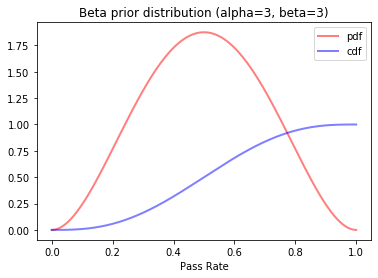

In [39]:
# weakly informative prior

import scipy.stats as ss

def plot_beta(x_range, a, b, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the f distribution function for a given x range, a and b
    If mu and sigma are not provided, standard beta is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.beta.cdf(x, a, b, mu, sigma)
    else:
        y = ss.beta.pdf(x, a, b, mu, sigma)
    plt.plot(x, y, **kwargs)
    
x = np.linspace(0, 1, 2000)

plot_beta(x, 3, 3, 0, 1, color='red', lw=2, ls='-', alpha=0.5, label='pdf')
plot_beta(x, 3, 3, 0, 1, cdf=True, color='blue', lw=2, ls='-', alpha=0.5, label='cdf')
plt.title("Beta prior distribution (alpha=3, beta=3)")
plt.xlabel("Pass Rate")
plt.legend();
plt.savefig('./figures/beta33.png')

In [30]:
pbp.isnull().sum(axis=0)

play_id       0
game_id       0
home_team     0
away_team     0
posteam       0
             ..
is_home       0
half          0
season        0
week          0
head_coach    0
Length: 261, dtype: int64

In [58]:
pbp.loc[:,'play_type'] = pbp.play_type.copy().replace({"run":"0","pass":"1"}).astype(int)

Instead of ML models I'll use pymc3 to estimate the base rate.

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pct_pass]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:01<00:00, 6386.99draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15aa98d10>,
      dtype=object)

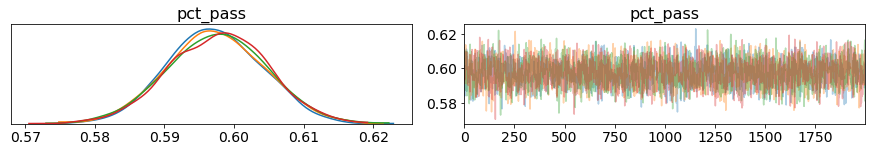

In [37]:
import pymc3 as pm

data = pbp[['head_coach','yards_for_td','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]
data.loc[:,'play_type'] = data.play_type.copy().replace({"run":"0","pass":"1"}).astype(int)

# shuffle data 
data = data.sample(frac=1)

# only need 5000 observations
data = data[:5000]

plays = data.play_type.values
n = len(plays)


with pm.Model() as model:
    pct_pass = pm.Beta('pct_pass', alpha=3, beta=3)
    y = pm.Bernoulli('likelihood', p=pct_pass, observed=plays)
    
    trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')
    
trarr = pm.traceplot(trace, var_names=['pct_pass'])

fig = plt.gcf() # to get the current figure...
fig.savefig("./figures/base_pass_rate.png") # and save it directly

trarr


In [43]:
print(pbp.score_differential.quantile(0.05))
print(pbp.score_differential.quantile(0.95))

-20.0
17.0


/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:11<00:00, 1051.57draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14baefd10>,
      dtype=object)

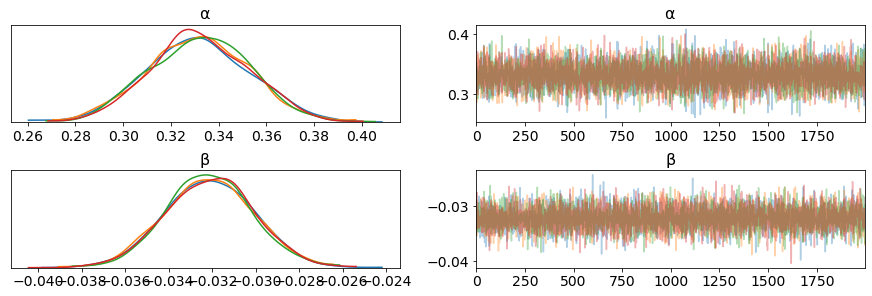

In [40]:
data = pbp[['score_differential','play_type']]
data.loc[:,'play_type'] = data.play_type.copy().replace({"run":"0","pass":"1"}).astype(int)

# shuffle data 
data = data.sample(frac=1)

# let's use 10,000 observations
data = data[:10000]

plays = data.play_type.values
covariate = data.score_differential.values
n = len(plays)

with pm.Model() as model:
    
    # priors
    α = pm.StudentT('α',nu=6,mu=0,sigma=4)
    β  = pm.StudentT('β',nu=6,mu=0,sigma=4)
    
    # linear regression, the engine behind logistic regression
    μ = α + β * covariate
    
    # link function theta - necessary for modeling Binary outcomes
    θ = pm.Deterministic('θ', pm.math.invlogit(μ))
    
    # observed/target
    y = pm.Bernoulli('y', p=θ, observed=plays)
    
    trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')
    
trarr = pm.traceplot(trace, var_names=['α','β'])

fig = plt.gcf() 
fig.savefig("./figures/one_covariate_trace.png") 

trarr


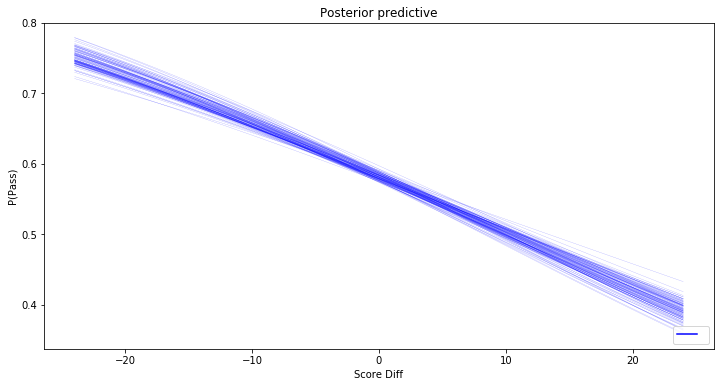

In [56]:
def lm_full(trace, score_diff):
    shape = np.broadcast(score_diff).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [score_diff]])
    # return inverse logit
    return 1 / (1 + np.exp(-(trace['α'] + 
                             trace['β']*x_norm[0])))

samples=1000
x = np.linspace(-17, 17, samples)

lm = lambda x, trace: lm_full(trace, x)

fig = plt.figure(figsize=(12,6))
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(-24,24,1000), lm=lm, samples=100, color='blue', alpha=.5)

import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b')
plt.legend(handles=[blue_line], loc='lower right')
plt.ylabel("P(Pass)")
plt.xlabel("Score Diff")
plt.savefig("./figures/score_diff.png")
plt.show()


In [61]:
# test for pass heavy coaches
data = pbp[['head_coach','score_differential','play_type']]

data.groupby(['head_coach'])['play_type'].count().reset_index().sort_values(by=['play_type'],ascending=False)

,head_coach,play_type
5,Bill Belichick,12090
44,John Harbaugh,11729
66,Mike Tomlin,11364
2,Andy Reid,11147
80,Sean Payton,10702
...,...,...
27,Gregg Williams,466
0,Aaron Kromer,349
57,Mel Tucker,309
22,Eric Studesville,256


In [60]:
data.groupby(['head_coach'])['play_type'].mean().reset_index().sort_values(by=['play_type'],ascending=False)


,head_coach,play_type
0,Aaron Kromer,0.727794
75,Rob Chudzinski,0.680075
9,Brian Flores,0.667954
28,Gus Bradley,0.641988
34,Jim Caldwell,0.641970
...,...,...
57,Mel Tucker,0.527508
22,Eric Studesville,0.523438
35,Jim Harbaugh,0.518434
74,Rex Ryan,0.515908


In [64]:
data = pbp[['head_coach','score_differential','play_type']]
data = data.loc[data.head_coach.isin(['Jim Harbaugh','Andy Reid'])]

# shuffle data 
data = data.sample(frac=1)

print("Andy Reid and Jim Harbaugh combined for {} plays in the dataset".format(len(data)))

plays = data.play_type.values
covariate = data.score_differential.values
n = len(plays)

with pm.Model() as model:
    
    # priors
    α = pm.StudentT('α',nu=6,mu=0,sigma=4)
    β  = pm.StudentT('β',nu=6,mu=0,sigma=4)
    
    # linear regression, the engine behind logistic regression
    μ = α + β * covariate
    
    # link function theta - necessary for modeling Binary outcomes
    θ = pm.Deterministic('θ', pm.math.invlogit(μ))
    
    # observed/target
    y = pm.Bernoulli('y', p=θ, observed=plays)
    
    trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')
    
trarr = pm.traceplot(trace, var_names=['α','β'])

fig = plt.gcf() 
fig.savefig("./figures/one_covariate_trace.png") 

trarr


Andy Reid and Jim Harbaugh combined for 15107 plays in the dataset


In [ ]:
# data = pbp[['head_coach','yards_for_td','ydstogo','down','half','half_seconds_remaining','score_differential','play_type']]

# le = LabelEncoder()
# le.fit(data.head_coach)

# data.loc[i_head_coach] = le.transform(data.head_coach.copy())
# print("there are {} head coaches in the dataset".format(data.head_coach.max()))

# coach_ids = data[['head_coach']]
# coach

# covariate = data.score_differential.values
# plays = data.play_type.values
# n = len(plays)

    
    



                              
# with pm.Model() as model:
#     pm.glm.GLM.from_formula('play_type ~ head_coach + yards_for_td + ydstogo + down + half + half_seconds_remaining + score_differential',
#                             data,
#                             family=pm.glm.families.Binomial())
#     trace = pm.sample(2000, chains=4, tune=1000, init='adapt_diag')


# stan_code = """

# data{
#     int<lower=1> I; //number features
#     int<lower=1> N; //number plays
    
#     matrix[N, I] X;
    
#     int<lower=0, upper=1> y[N]; // target
# }

# parameters{
#     vector[I] beta;
#     real alpha; // intercept, as in traditional linear regression
# }

# //transformed parameters{
# //}

# model{
#     // covariate priors (essentially ignorant)
#     beta ~ normal(0,10);
#     alpha ~ normal(0,10);
    
#     // "bernoulli logit" is special stan syntax that speeds up processing
#     y ~ bernoulli_logit(X * beta + alpha); // linear function, inside link function 
# }

# """

# play_data = {
#     'I':X.shape[1],
#     'N':len(mdf),
#     'X':X,
#     'y':plays
# }


# sm = pystan.StanModel(model_code=stan_code)
# fit = sm.sampling(data=play_data)


In [ ]:
# trarr = pm.traceplot(trace, var_names=['α','β'])

# fig = plt.gcf() # to get the current figure...
# fig.savefig("./figures/simple_logit.png") # and save it directly

# pm.traceplot(trace, var_names=['α','β'])

In [ ]:
# p = trace.get_values('p', burn=niter//2, combine=True, chains=[0,4])
# pm.traceplot(trace, var_names=['p'])

In [ ]:
# le.classes_

In [ ]:
# df_hpd = pd.DataFrame(pm.stats.hpd(trace['head_coach']),
#                       columns=['hpd_low', 'hpd_high'],
#                       index=le.classes_)
# df_median = pd.DataFrame(np.quantile(trace['head_coach'], 0.5, axis=0),
#                          columns=['hpd_median'],
#                          index=le.classes_)
# df_hpd = df_hpd.join(df_median)
# df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
# df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
# df_hpd = df_hpd.sort_values(by='hpd_median')
# df_hpd = df_hpd.reset_index()
# df_hpd['x'] = df_hpd.index + .5


# fig, axs = plt.subplots(figsize=(13,7))
# axs.errorbar(df_hpd.x, df_hpd.hpd_median,
#              yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
#              fmt='o')
# axs.set_title('CI of QB Touchdown Expectation')
# axs.set_xlabel('Team')
# axs.set_ylabel('Posterior QB Touchdown Expectation')
# _= axs.set_xticks(df_hpd.index + .5)
# _= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

# plt.savefig('./figures/CI_HC.png')